# DCGAN with Parasitized Images

In [36]:
%load_ext tensorboard
import os
from glob import glob
import time
import random

import IPython.display as display
import matplotlib.pyplot as plt # Matplotlib is used to generate plots of data.
import matplotlib.image as mpimg
import PIL
from PIL import Image
import imageio
import numpy as np # Numpy is an efficient linear algebra library.

import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/cell_images_32.zip" -d cell_images_32/

Streaming output truncated to the last 5000 lines.
  inflating: cell_images_32/cell_image_ (5776).png  
  inflating: cell_images_32/cell_image_ (4366).png  
  inflating: cell_images_32/cell_image_ (2884).png  
 extracting: cell_images_32/cell_image_ (3498).png  
  inflating: cell_images_32/cell_image_ (4110).png  
  inflating: cell_images_32/cell_image_ (948).png  
  inflating: cell_images_32/cell_image_ (403).png  
  inflating: cell_images_32/cell_image_ (4972).png  
  inflating: cell_images_32/cell_image_ (4493).png  
  inflating: cell_images_32/cell_image_ (2130).png  
  inflating: cell_images_32/cell_image_ (3352).png  
  inflating: cell_images_32/cell_image_ (2742).png  
  inflating: cell_images_32/cell_image_ (1999).png  
  inflating: cell_images_32/cell_image_ (3241).png  
  inflating: cell_images_32/cell_image_ (1979).png  
  inflating: cell_images_32/cell_image_ (2435).png  
  inflating: cell_images_32/cell_image_ (1952).png  
  inflating: cell_images_32/cell_image_ (2280).png

In [4]:
# Experiment paths
# Save the model for further use
EXPERIMENT_ID = "train_1"
MODEL_SAVE_PATH = os.path.join("/content/cell_images_32/results/", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

# Data path
DATA_PATH = "/content/cell_images_32/"

# Model parameters
BATCH_SIZE = 64
EPOCHS = 20000
LATENT_DEPTH = 100
IMAGE_SHAPE = [32,32]
n_ch = 3
LR = 1e-4

seed = random.seed(30)

In [5]:
image_count = len(list(glob(str( DATA_PATH + '*.png'))))
image_count

6000

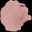

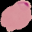

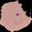

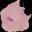

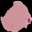

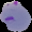

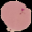

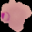

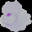

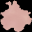

In [6]:
cell_images_path = list(glob(str(DATA_PATH + '*.png')))
for image_path in cell_images_path[:10]:
    display.display(Image.open(str(image_path)))

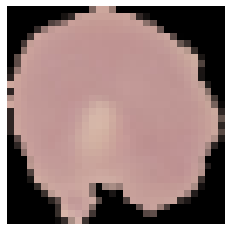

In [7]:
# Read in the image
image = mpimg.imread(cell_images_path[20])

plt.axis("off")
plt.imshow(image)

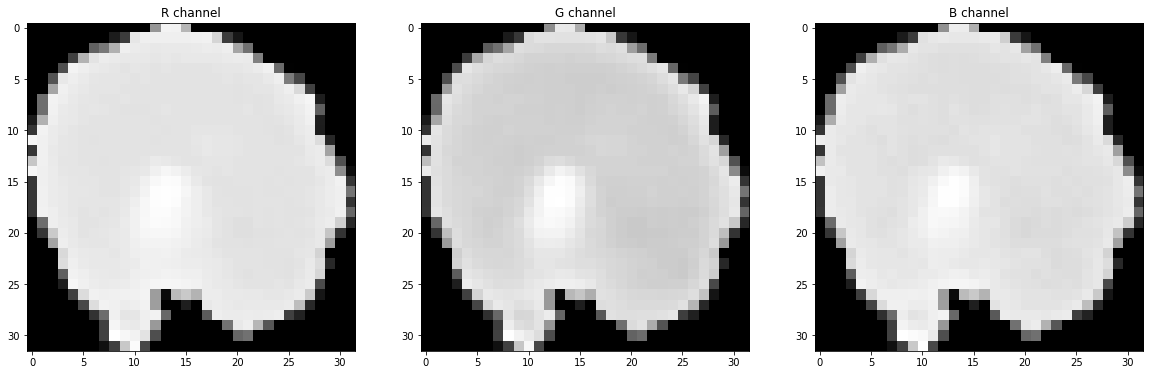

In [8]:
# Isolate RGB channels
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

In [9]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [10]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(10* BATCH_SIZE)
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


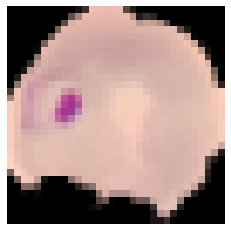

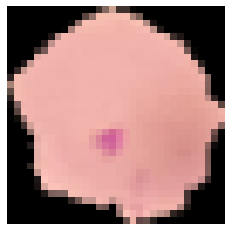

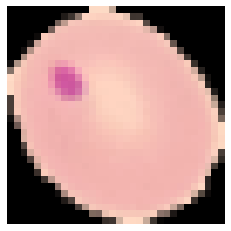

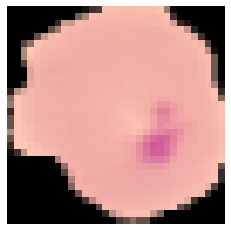

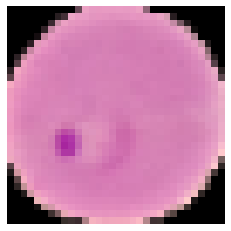

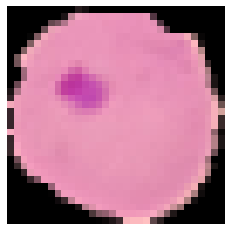

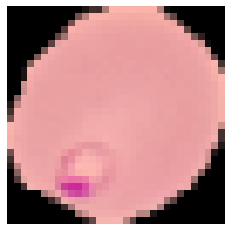

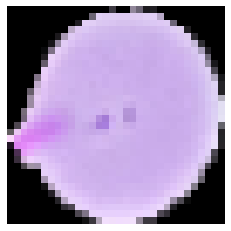

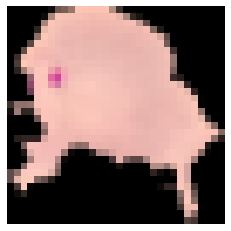

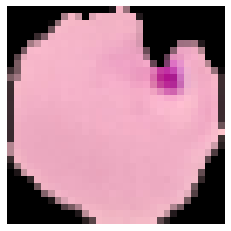

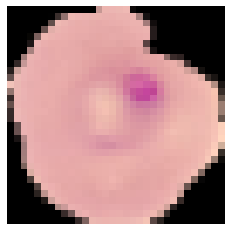

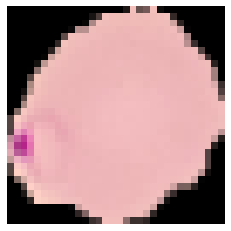

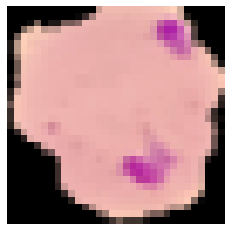

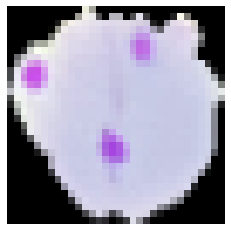

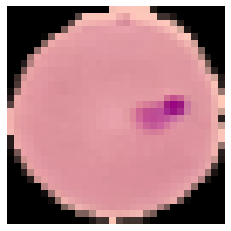

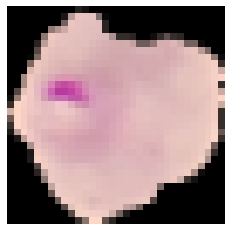

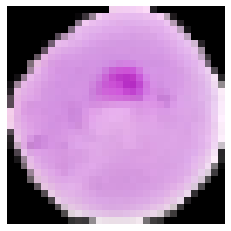

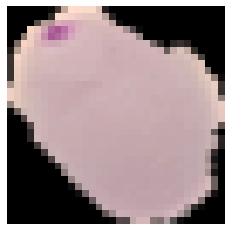

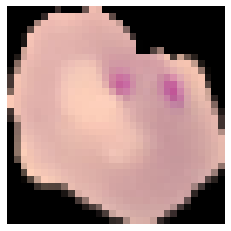

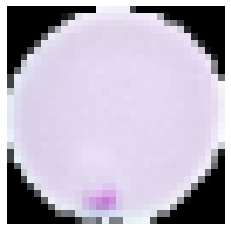

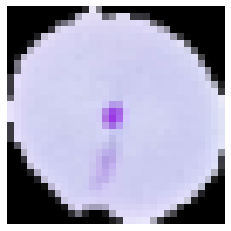

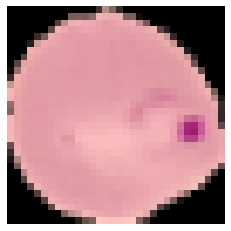

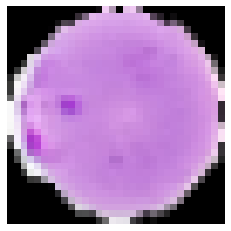

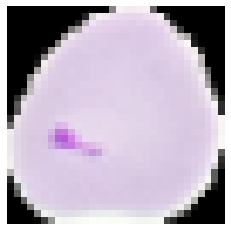

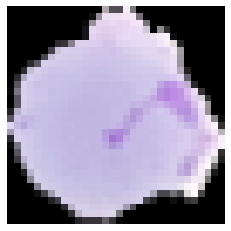

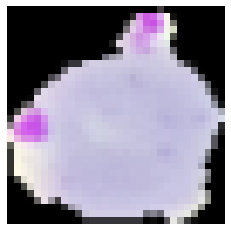

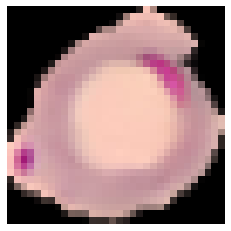

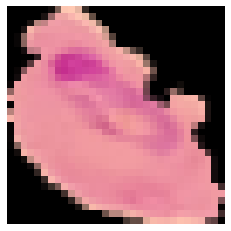

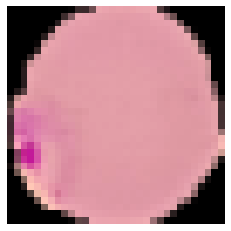

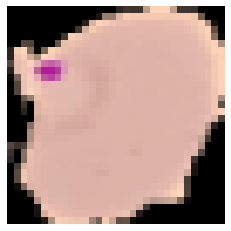

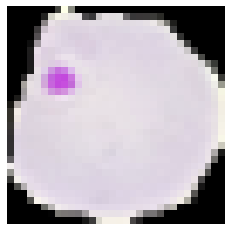

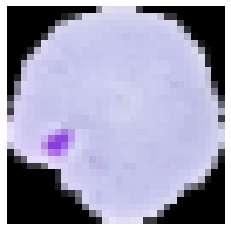

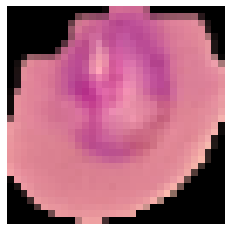

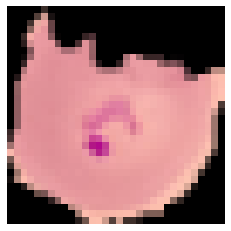

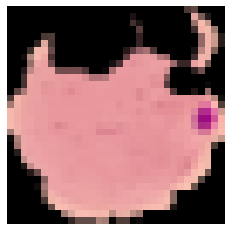

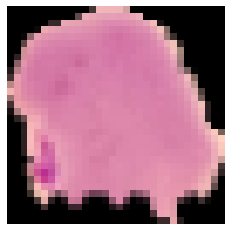

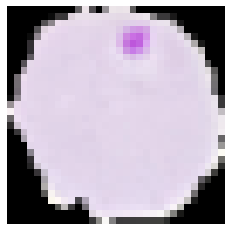

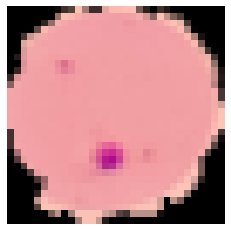

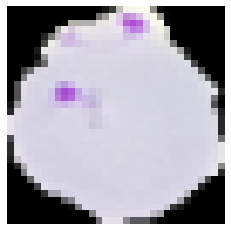

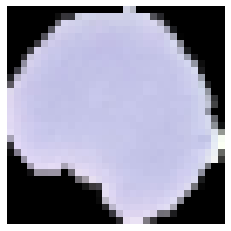

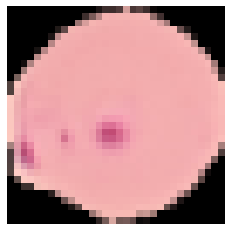

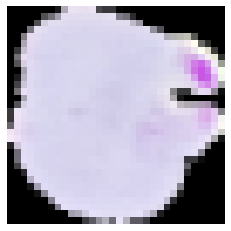

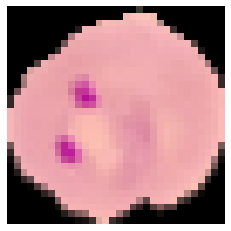

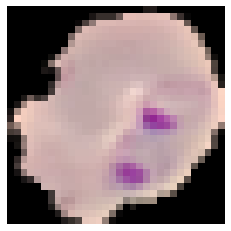

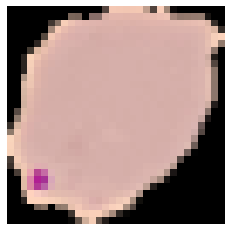

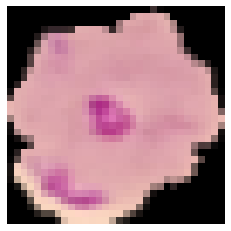

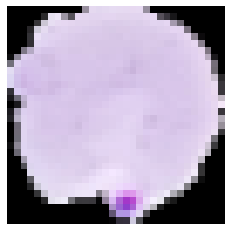

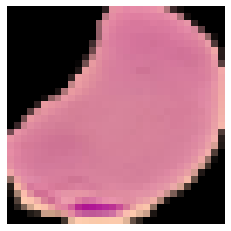

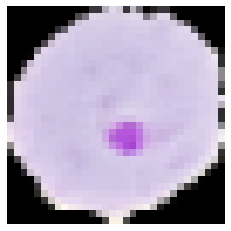

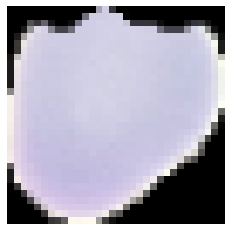

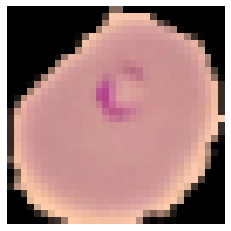

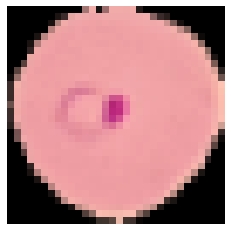

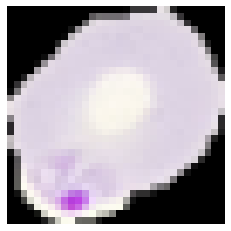

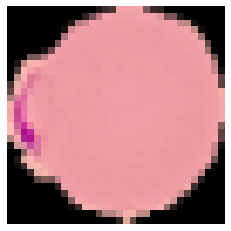

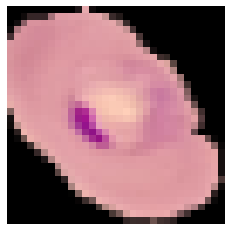

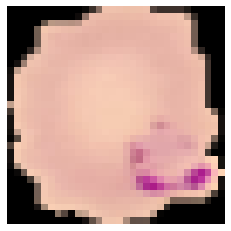

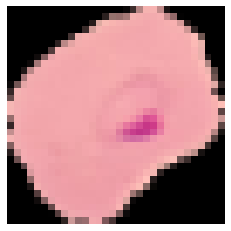

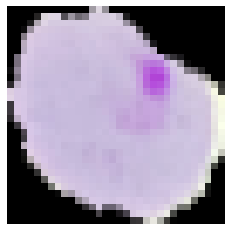

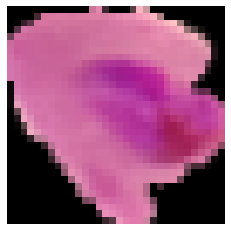

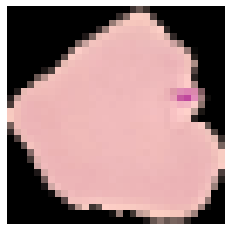

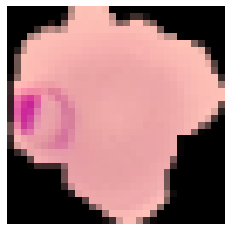

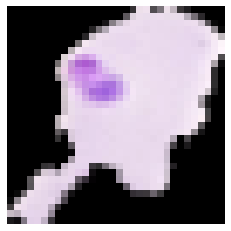

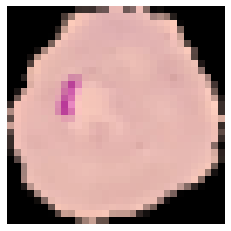

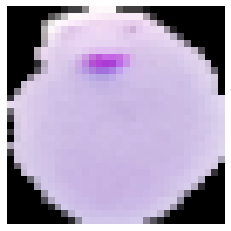

In [11]:
dataset = dataloader(cell_images_path)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

In [12]:
image_list = []
for filename in cell_images_path:
    im=Image.open(filename)
    im =im.resize((IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
    image_list.append(im)

In [13]:
images_processed = []
for image in image_list:
    gan_train_images = np.asarray(image)
    gan_train_images = gan_train_images.astype('float32') /255.0
    images_processed.append(gan_train_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


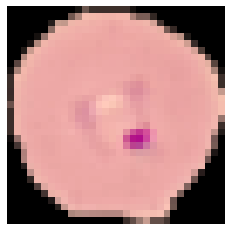

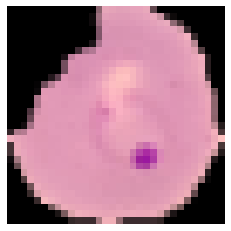

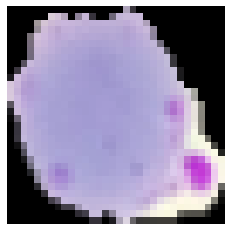

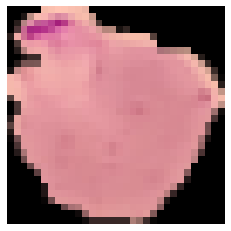

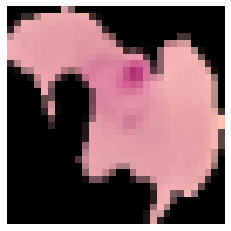

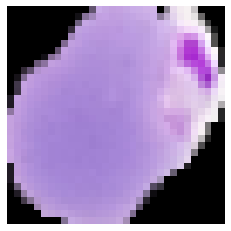

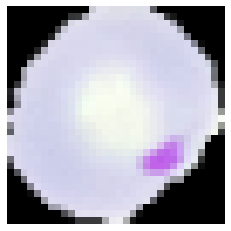

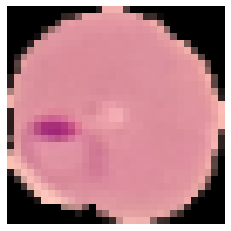

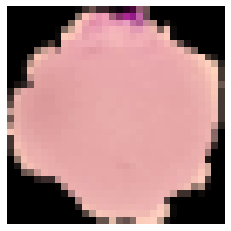

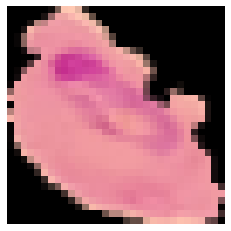

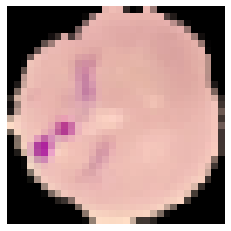

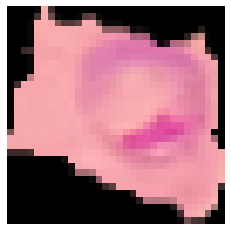

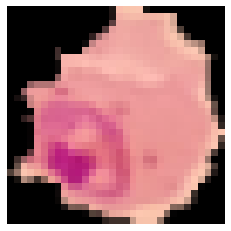

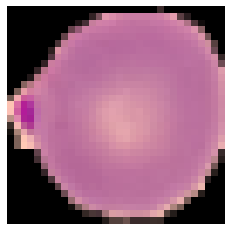

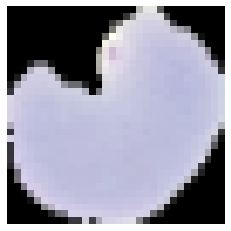

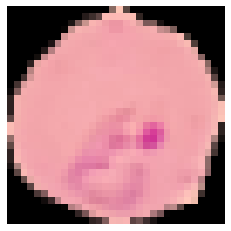

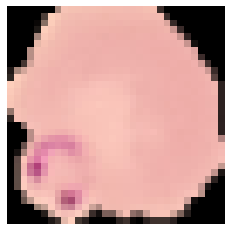

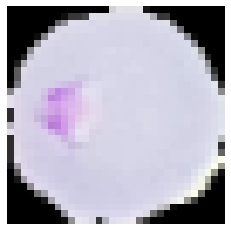

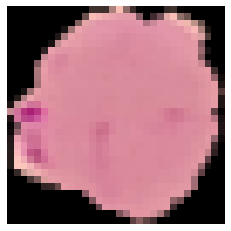

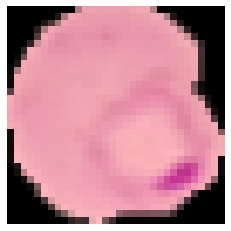

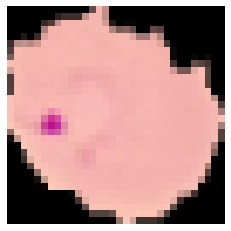

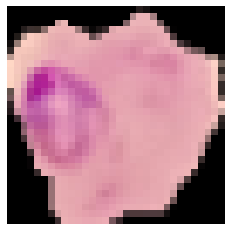

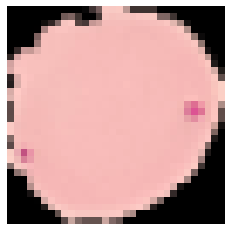

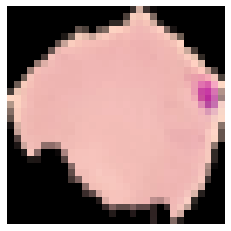

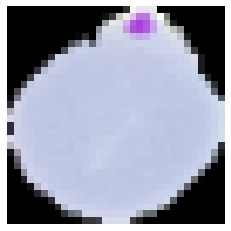

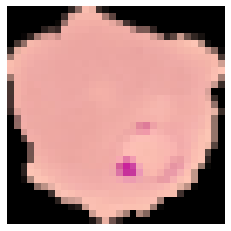

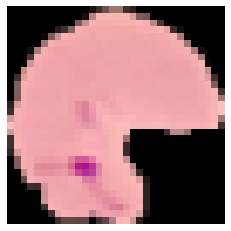

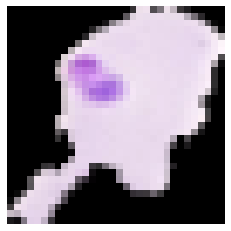

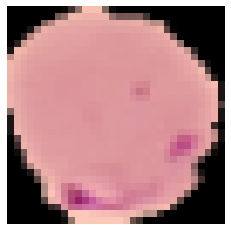

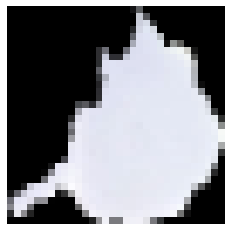

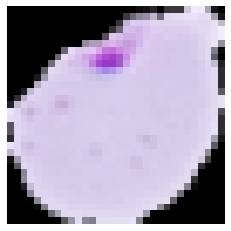

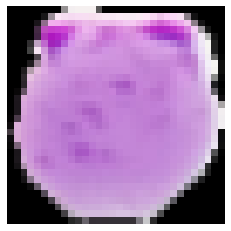

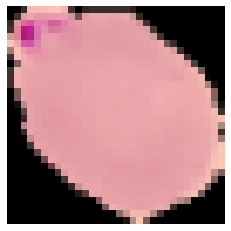

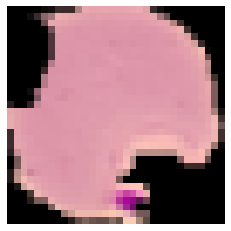

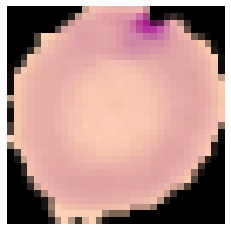

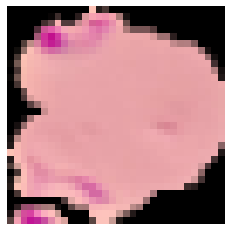

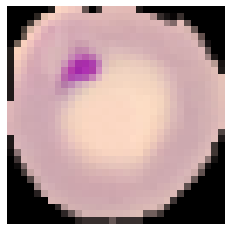

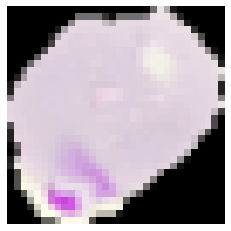

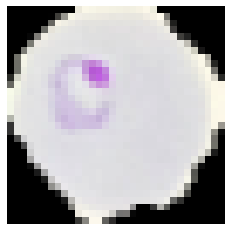

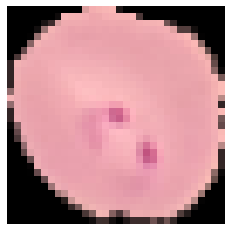

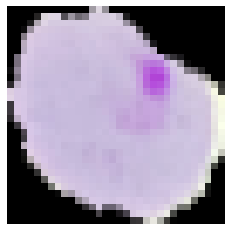

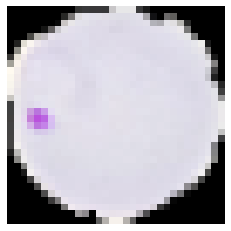

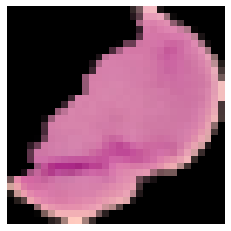

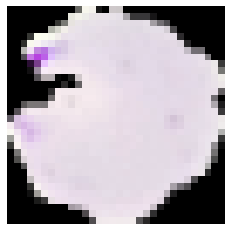

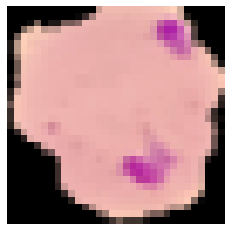

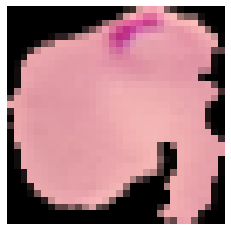

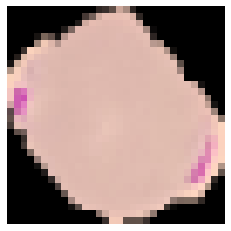

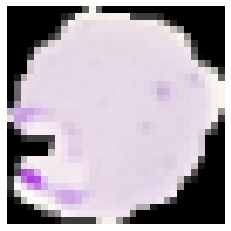

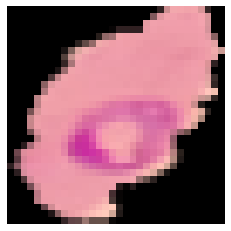

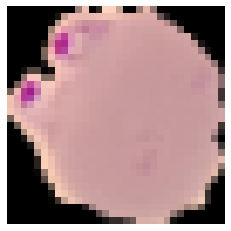

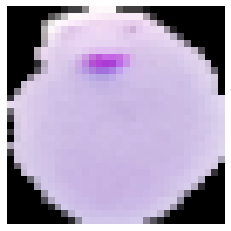

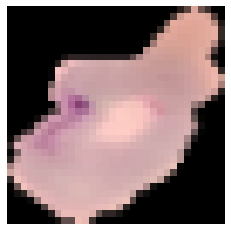

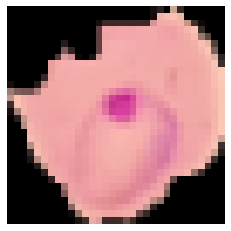

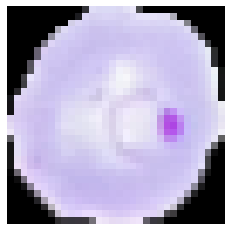

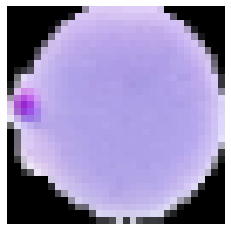

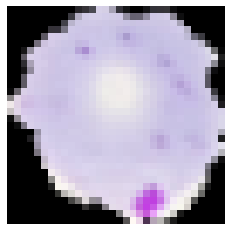

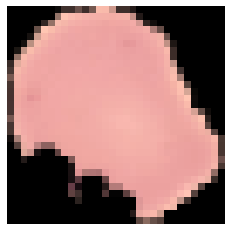

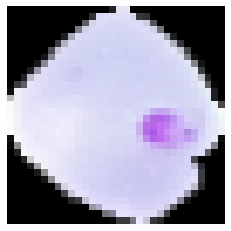

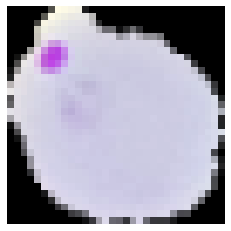

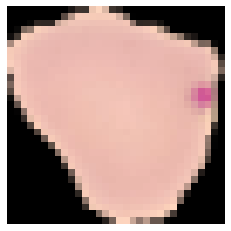

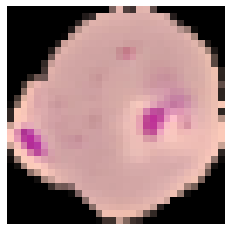

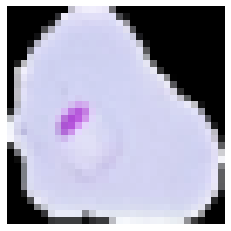

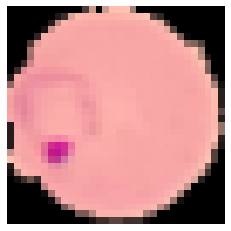

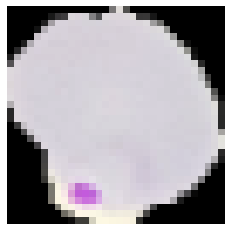

In [14]:
dataset = tf.data.Dataset.from_tensor_slices(images_processed).shuffle(10* BATCH_SIZE).batch(BATCH_SIZE)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

## Creating the model
Generator and Discriminator are defined using [Keras Sequential API] 


In [15]:
# Let's make genrator model function

def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU())


    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256) 


    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', 
                                     use_bias=False, activation='tanh')) 
    assert model.output_shape == (None, 32, 32, 3) 

    return model

Let's create an image using a generator that hasn't been trained yet.

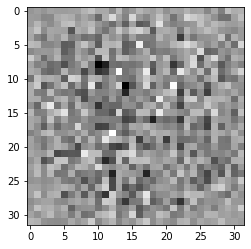

In [16]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
 
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00040819]], shape=(1, 1), dtype=float32)


In [19]:
# This method returns a helper function to compute the cross entropy loss. (for Binary Classification)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
# Use Adam as the Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoint
This notebook shows you how to save and restore models that can be useful in cases where long-running training is disrupted.

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Experiment utils (RUN ME!)

In [26]:
# Define the training loop

EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [28]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Model Traning

In [29]:
# Create and save images

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

# Instantly create images for GIF.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


# It saves the model every 15 epoch passes
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    

 # print the report on how much time it takes for each epoch
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate after the last epoch is over.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


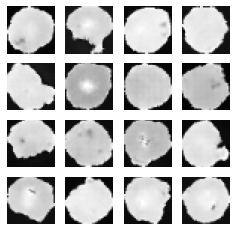

CPU times: user 3h 26min 59s, sys: 7min 37s, total: 3h 34min 37s
Wall time: 3h 7min 3s


In [31]:
# Model training
%%time
train(dataset, EPOCHS)

In [32]:
# Restore the last checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
# Create GIF
# Displays a single image using epoch numbers.

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

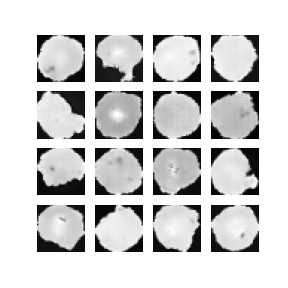

In [34]:
display_image(EPOCHS)

In [39]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob(os.path.join(MODEL_SAVE_PATH, 'image*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [40]:
# If you are working at Colab, you can download the animation from the code below:

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>